# Compression d'une image couleur
vincent.mazet@unistra.fr, 03/2022

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.color import ycbcr2rgb, rgb2ycbcr
# from skimage.util import img_as_float, img_as_ubyte, img_as_uint
from skimage.transform import resize
import skimage.io as io
from scipy.fftpack import dctn, idctn

La compression JPEG s'effectue en plusieurs étapes.
Deux étapes en particulier sont particulièrement importantes pour la compression avec perte :
- le sous-échantillonnage de l'image dans l'espace couleur YCbCr,
- la quantification des coefficients de la DCT de l'image.

## Espace YCbCr

Il existe beaucoup d'espaces couleurs, le plus courant étant RVB.
YCbCr est un autre espace de couleur dont les composantes sont :
* la luminosité Y,
* la chrominance bleue Cb
* la chrominance rouge Cr

L'intérêt de l'utilisation de l'espace YCbCr pour la compression JPEG est que l'œil humain est très sensible à la luminosité, et moins au chrominance.
On peut donc compresser plus fortement les chrominances que la luminosité, afin de gagner en espace mémoire.

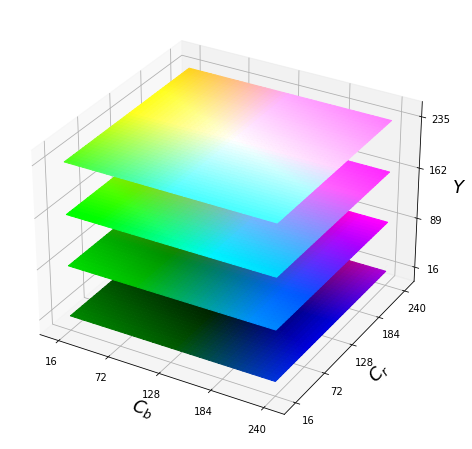

In [2]:
# Paramètres d'affichage
B = 4           # Nombre de bandes
N = 235-16+1    # Taille des images
R = 50          # Résolution des bandes (de taille R×R)

# Valeurs de Y
y = np.linspace(16, 235, B)

# Valeurs de Cb et Cr
c = np.linspace(16, 240, N)
    
# Initialisation de l'affichage
z = np.ones((N,N))
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')
ax.set_xlabel('$C_b$', fontsize=18)
ax.set_ylabel('$C_r$', fontsize=18)
ax.set_zlabel('$Y$'  , fontsize=18)
d = 16
ax.set_xlim([16-d, 240+d])
ax.set_ylim([16-d, 240+d])
ax.set_zlim([16-d, 235+d])
ax.set_xticks(np.linspace(16, 240, 5))
ax.set_yticks(np.linspace(16, 240, 5))
ax.set_zticks(y)

# Liste contenant l'ensemble des bandesx
for Y in y:
    
    Cb, Cr = np.meshgrid(c,c)
    
    ycbcr = np.zeros((N,N,3))
    ycbcr[:,:,0] = Y
    ycbcr[:,:,1] = Cb
    ycbcr[:,:,2] = Cr
    
    img = ycbcr2rgb(ycbcr)
    
    img = np.clip(img, 0, 1)
    ax.plot_surface(Cb, Cr, Y*z, rcount=R, ccount=R, facecolors=img, shade=False)

plt.show()

## Image originale

Comme illustration, nous utiliserons cette image :

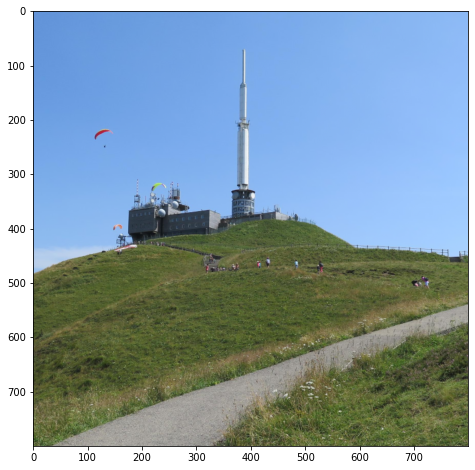

In [3]:
rgb = io.imread('puy-du-dome.jpg')
rgb = resize(rgb, (800, 800, 3))
N, _, _ = rgb.shape

fig, axs = plt.subplots(1,1,figsize=(20,8))
axs.imshow(rgb)
plt.show()

Les bandes RVB de cette image sont :

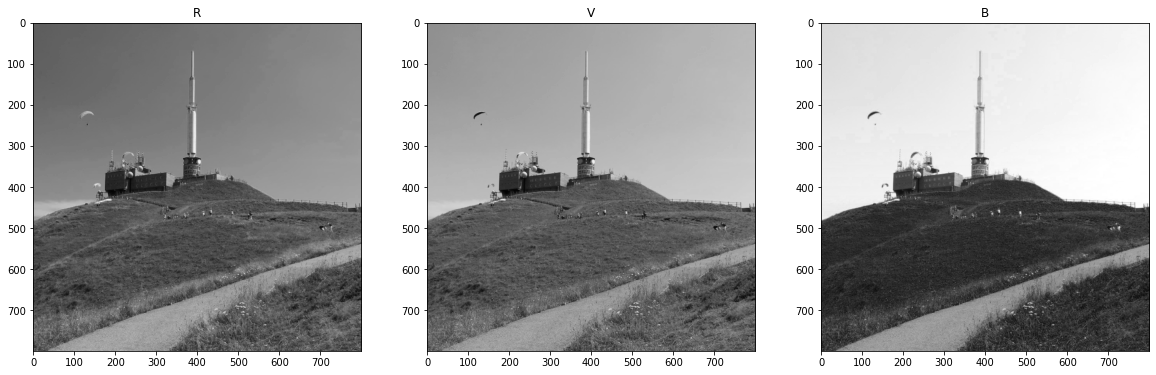

In [4]:
fig, axs = plt.subplots(1,3,figsize=(20,8))
for i in range(3):
    axs[i].imshow(rgb[:,:,i], cmap="gray")
    axs[i].set_title(["R", "V", "B"][i])
plt.show()

Les bandes YCbCr de cette image sont :

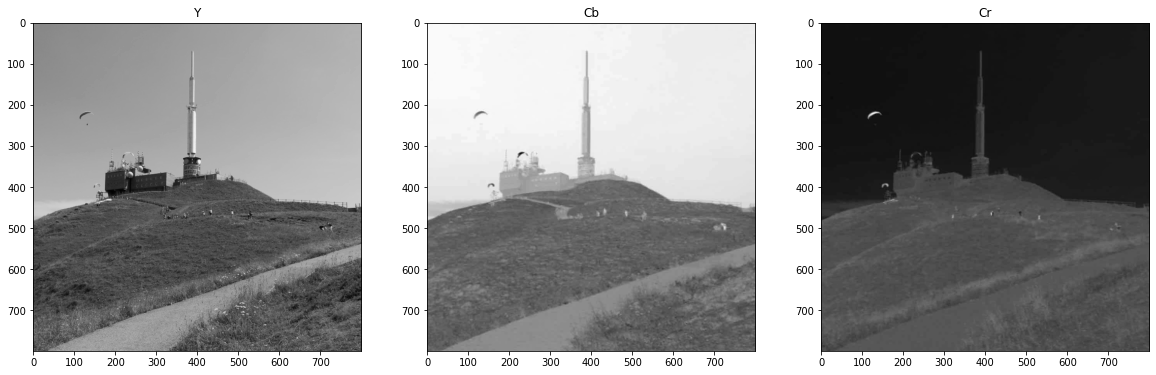

In [5]:
# Bandes Y, Cb, Cr
ycbcr = rgb2ycbcr(rgb)

fig, axs = plt.subplots(1,3,figsize=(20,8))
for i in range(3):
    axs[i].imshow(ycbcr[:,:,i], cmap="gray")
    axs[i].set_title(["Y", "Cb", "Cr"][i])
plt.show()

## Sous-échantillonnage

Voici l'image qu'on obtient en sous-échantillonnant d'un facteur 10 l'une de ces bandes :

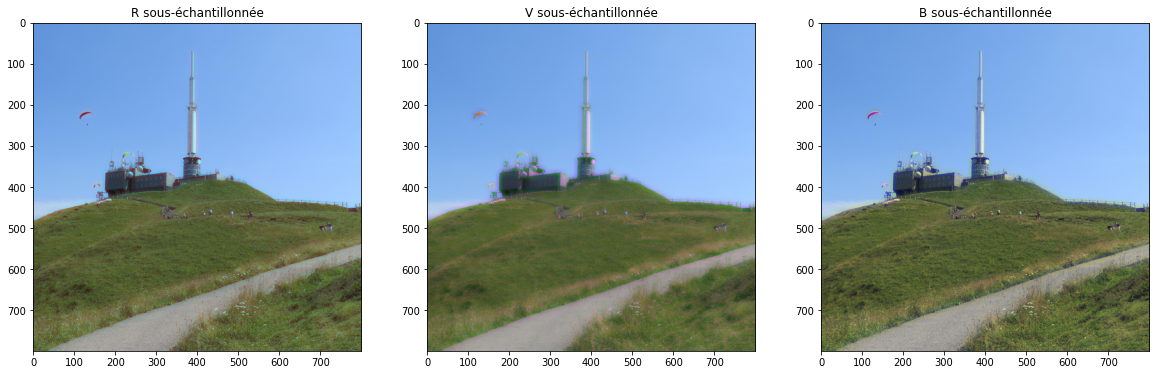

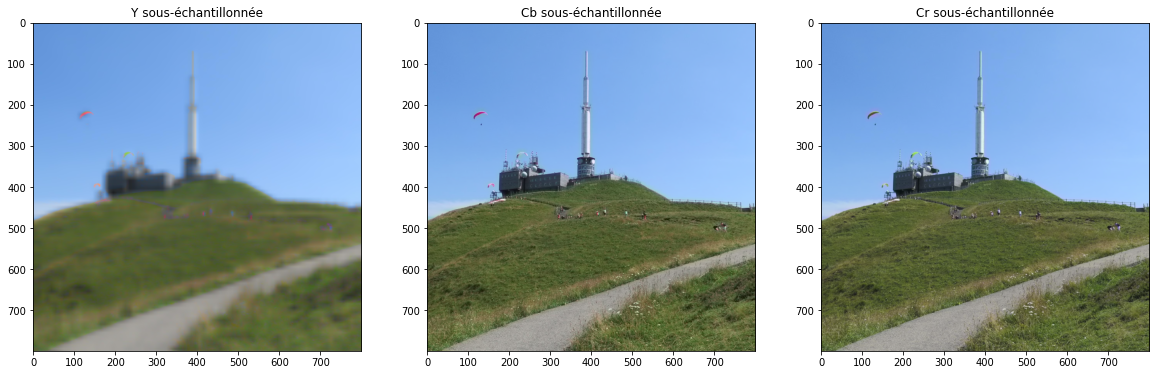

In [6]:
F = 10

def downsampleband(img, band):
    
    # Initialisation
    rec = img.copy()
    N, _, _ = rec.shape
    
    # Sous-échantillonnage
    downsampled = resize(rec[:,:,band], (N/F, N/F))
    
    # Ré-échantillonnage
    downsampled = resize(downsampled, (N, N))
    
    # Nouvelle image
    rec[:,:,band] = downsampled
    
    return rec

fig, axs = plt.subplots(1,3,figsize=(20,8))
t = ["R", "V", "B"]
for b in range(3):
    rec = downsampleband(rgb, b)
    axs[b].imshow(rec)
    axs[b].set_title(f"{t[b]} sous-échantillonnée")

fig, axs = plt.subplots(1,3,figsize=(20,8))
t = ["Y", "Cb", "Cr"]
for b in range(3):
    rec = downsampleband(ycbcr, b)
    rec = ycbcr2rgb(rec)
    rec = np.clip(rec, 0, 1)
    axs[b].set_title(f"{t[b]} sous-échantillonnée")
    axs[b].imshow(rec)

On constate que le même sous-échantillonnage est beaucoup plus visible sur Y que Cb et Cr.
C'est pourquoi la compression JPEG effectue un sous-échantillonnage des chrominances mais pas de la luminance (ou très peu).

## Quantification des coefficients de la DCT

Pour l'illustration de l'effet de la quantification des coefficients, nous considérons une sous-image, dont la DCT est :

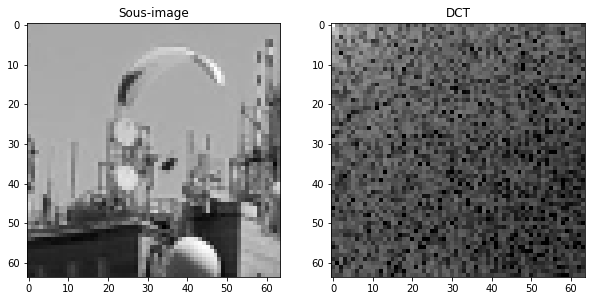

In [7]:
# DCT sur une imagettes
z = 64
r, c = 310, 195
img = ycbcr[r:(r+z),c:(c+z),0]
dec = dctn(img, norm='ortho')
logdec = np.log(np.abs(dec+1e-12))

logdec = np.clip(logdec, -1, 15)
logdec = (logdec+1) / (15+1)

fig, axs = plt.subplots(1,2,figsize=(10,8))
axs[0].imshow(img, cmap="gray")
axs[0].set_title("Sous-image")
axs[1].imshow(logdec, cmap="gray")
axs[1].set_title("DCT")
plt.show()

mini, maxi = logdec.min(), logdec.max()

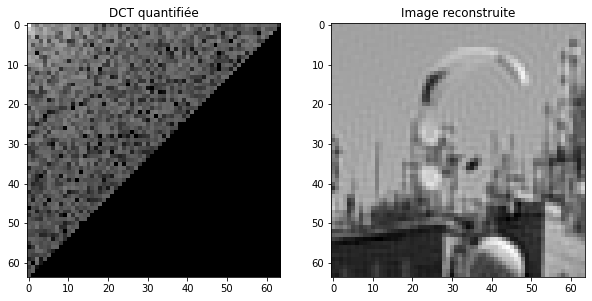

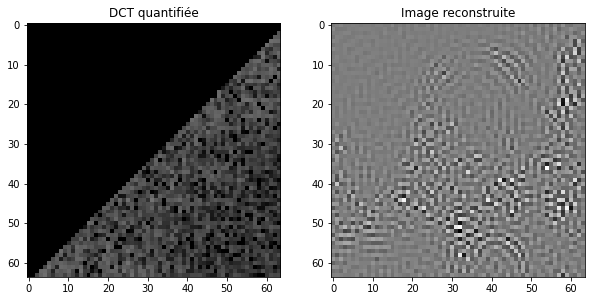

In [8]:
# Quantification très grossière = annulation des coefficients

x, y = np.meshgrid(range(0,z), range(0,z))

for f in range(2):

    if f==0:
        f = dec * (x+y < z)
    else:
        f = dec * (x+y > z)
        
    logdec = np.log(np.abs(f+1e-12))
    logdec = np.clip(logdec, -1, 15)
    logdec = (logdec+1) / (15+1)

    # Reconstruction
    rec = idctn(f, norm='ortho')
    
    # Affichage
    fig, axs = plt.subplots(1,2,figsize=(10,8))
    axs[0].imshow(logdec, cmap="gray", vmin=mini, vmax=maxi)
    axs[0].set_title("DCT quantifiée")
    axs[1].imshow(rec, cmap="gray")
    axs[1].set_title("Image reconstruite")

## Le tout combiné...

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Taux de compression : 8 %


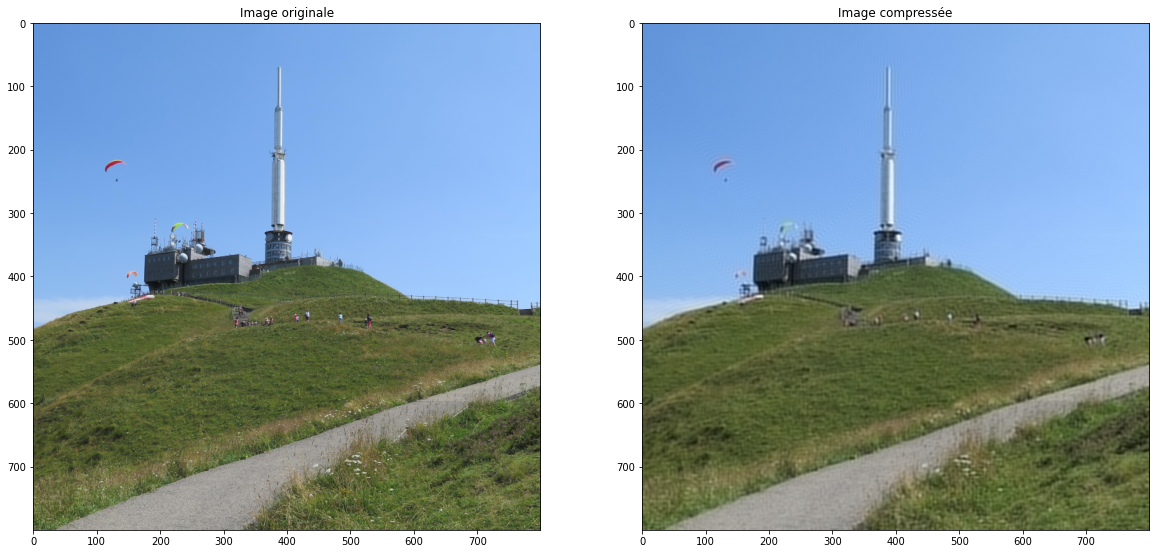

In [11]:
# Facteurs de compression
F1 = 10
R = .2

# Image originale
N = 800
rgb = io.imread('puy-du-dome.jpg')
rgb = resize(rgb, (N, N, 3))
ycbcr = rgb2ycbcr(rgb)

# # Sous-échantillonnage des chrominances
for b in range(1,3):
    downsampled = resize(ycbcr[:,:,b], (N/F1, N/F1))
    ycbcr[:,:,b] = resize(downsampled, (N, N))
    
# Quantification de la DCT
x, y = np.meshgrid(range(0,N), range(0,N))
mask = (x+y < 2*N * R)
F2 = len(np.nonzero(mask.ravel())[0]) / (N*N)
for b in range(3):
    coef = dctn(ycbcr[:,:,b], norm='ortho')
    coef = mask * coef
    ycbcr[:,:,b] = idctn(coef, norm='ortho')
    
# Reconstruction RVB
compressed = ycbcr2rgb(ycbcr)

# Taux de compression
num = (N*N*R) + (N*N*R/F1) + (N*N*R/F1)
den = (N*N*3)
taux = num/den
print(f"Taux de compression : {taux*100:.0f} %")

fig, axs = plt.subplots(1,2,figsize=(20,10))
axs[0].imshow(rgb)
axs[0].set_title("Image originale")
axs[1].imshow(compressed)
axs[1].set_title("Image compressée")
plt.show()